In [1]:
import pandas as pd

df = pd.read_csv('urteile.csv', )
df.drop('Unnamed: 0', axis=1, inplace=True)
df

In [2]:
df['nationalitaet'].value_counts()

In [3]:
df['hauptdelikt'].value_counts()

In [4]:
kategorie_feld = 'gericht'
hauptdelikt_kategorien = list(df[kategorie_feld].value_counts().index)
kat_dict = dict()
for kategorie in hauptdelikt_kategorien:
    kat_dict[kategorie] = df[df[kategorie_feld] == kategorie]
kat_dict.keys()

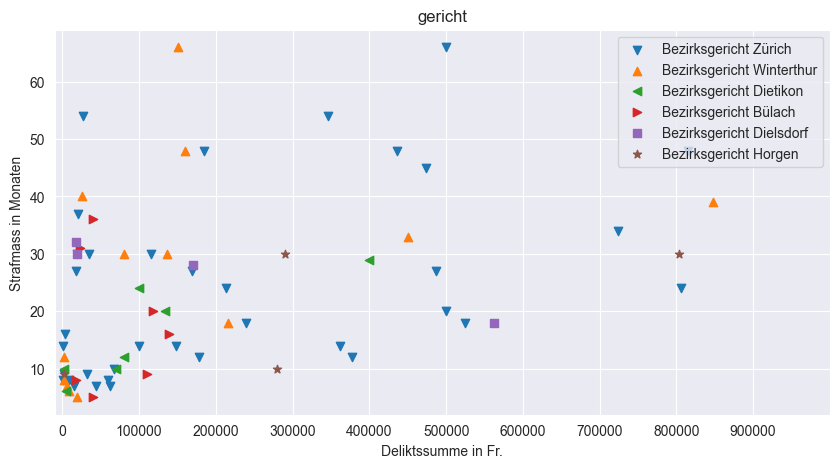

In [5]:
from matplotlib import pyplot as plt
import numpy as np

xlim = 1000000
titel = kategorie_feld
markers=["v", "^", "<", ">", "s", "*"]

fig, ax = plt.subplots(figsize=(10, 5))
for kategorie, marker in zip(kat_dict.keys(), markers[:len(kat_dict.keys())]):
    ax.scatter(x=kat_dict[kategorie]['deliktssumme'], y=kat_dict[kategorie]['freiheitsstrafe_in_monaten'], marker=marker,
               label=kategorie)
ax.set_xlabel('Deliktssumme in Fr.')
ax.set_xlim([-10000, xlim])
ax.set_xticks(np.arange(0, xlim, (xlim/10)))
ax.set_ylabel('Strafmass in Monaten')
ax.set_title(titel)
ax.legend(loc='best')

In [6]:
df['urteilsdatum'] = pd.to_datetime(df['urteilsdatum'])
df['urteilsdatum'] = df['urteilsdatum'].map(lambda a : a.year)
df.rename(columns={'urteilsdatum': 'urteilsjahr'}, inplace=True)

## Vorbehandlung der Daten (one hot encode), x und y erstellen

In [7]:
verwendete_kategoriale_features = ['geschlecht', 'nationalitaet', 'gericht', 'mehrfach', 'gewerbsmaessig', 'vorbestraft', 'vorbestraft_einschlaegig', 'hauptdelikt']
verwendete_numerische_features = ['deliktssumme', 'nebenverurteilungsscore', 'urteilsjahr']
df_kat = df[verwendete_kategoriale_features]
df_num = df[verwendete_numerische_features]

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
df_kat_1hot = encoder.fit_transform(df_kat)
encoder_feature_names = encoder.get_feature_names_out(['geschlecht', 'nationalitaet', 'gericht', 'mehrfach', 'gewerbsmaessig', 'vorbestraft', 'vorbestraft_einschlaegig', 'hauptdelikt'])
df_kat_1hot_df = pd.DataFrame(df_kat_1hot, columns=encoder_feature_names)
x = pd.concat([df_kat_1hot_df, df_num], axis=1)

In [8]:
y = df[['freiheitsstrafe_in_monaten']].values.ravel()

## Arbeiten mit linear regression

In [9]:
from sklearn.linear_model import LinearRegression
lin_regression = LinearRegression().fit(x, y)
coeff_features_list = list(zip(lin_regression.coef_, lin_regression.feature_names_in_))
koeff_liste = sorted(coeff_features_list, key=lambda tup: tup[0])
koeff_liste

In [10]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
liste_der_abweichungen = []
liste_der_ids = []
for train, test in loo.split(x):
    lin_regression.fit(x.iloc[train], df['freiheitsstrafe_in_monaten'].iloc[train])
    vorhersage = lin_regression.predict(x.iloc[test])
    tatsaechliches_strafmass = df['freiheitsstrafe_in_monaten'].iloc[test].values[0]
    differenz = abs(vorhersage[0] - tatsaechliches_strafmass)
    liste_der_abweichungen.append(differenz)
    liste_der_ids.append(df['id'].iloc[test].values[0])
durchschschnittlicher_fehler = np.mean(liste_der_abweichungen)
standardabweichung = np.std(liste_der_abweichungen)
print(f'Durschnittlicher Fehler: {round(durchschschnittlicher_fehler, 2)}')
print(f'Standardabweichung: {round(standardabweichung, 2)}')
print(f'Beste Prognoseleistung (Differenz): {round(np.min(liste_der_abweichungen), 2)}')
print(f'Schlechteste Prognoseleistung (Differenz): {round(np.max(liste_der_abweichungen), 2)}')
liste_der_abweichungen2 = liste_der_abweichungen.copy()
for differenz in liste_der_abweichungen2:
    if differenz < durchschschnittlicher_fehler - standardabweichung or differenz > durchschschnittlicher_fehler + standardabweichung:
        index = liste_der_abweichungen2.index(differenz)
        liste_der_abweichungen2[index] = 'ausserhalb'
ausserhalb_standardabweichung = liste_der_abweichungen2.count('ausserhalb')

print(f'{round((len(liste_der_abweichungen2) - ausserhalb_standardabweichung) / len(liste_der_abweichungen2) * 100, 2)}% aller Prognosen weisen einen Fehler zwischen {round(durchschschnittlicher_fehler - standardabweichung, 2)} und {round(durchschschnittlicher_fehler + standardabweichung, 2)} Monaten auf')

In [11]:
abweichung_id_tuple_list = list(zip(liste_der_abweichungen, liste_der_ids))
abweichung_id_tuple_list = sorted(abweichung_id_tuple_list, key= lambda row : row[0])
abweichung_id_tuple_list
beste_prognose = df[df.id == abweichung_id_tuple_list[0][1]]
beste_prognose

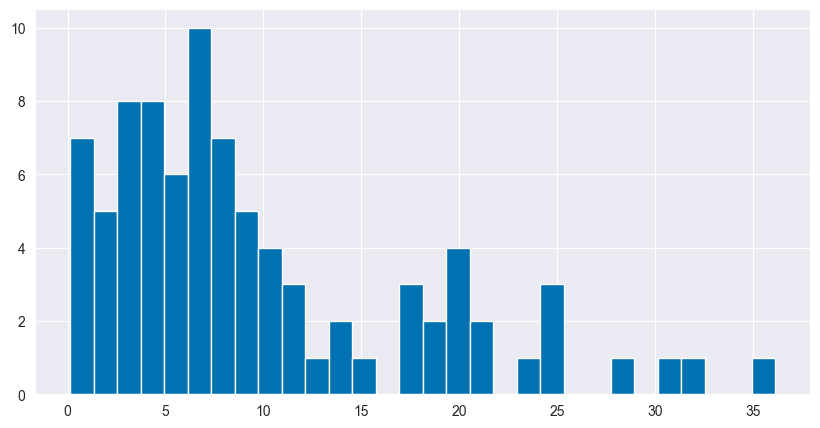

In [12]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(liste_der_abweichungen, bins=30)

## Arbeiten mit Random Forest (alle features)

In [13]:
from sklearn.ensemble import RandomForestRegressor
regressor= RandomForestRegressor(random_state=42,
                                  max_depth=110,
                                  min_samples_split = 2,
                                  min_samples_leaf= 4,
                                  n_estimators=10)
regressor.fit(x, y)
list_of_importance_feature_tuples = list(zip(regressor.feature_importances_, regressor.feature_names_in_))
sorted_list_of_importance_feature_tuples = sorted(list_of_importance_feature_tuples, key=lambda tup: tup[0], reverse=True)
for tuple in sorted_list_of_importance_feature_tuples:
    print(tuple[1], round(tuple[0]*100, 2))

In [14]:
# Kategorien wieder zusammenfassen
zusammenfassende_list_of_zipped_importance_features_tuples = sorted_list_of_importance_feature_tuples.copy()

# 1hot kategorisierte kategoriale Variablen wieder zusammenrechnen
zusammenfassende_kategorien = ['gericht', 'hauptdelikt', 'vorbestraft', 'nationalitaet', 'geschlecht', 'gewerbsmaessig']
for kategorie in zusammenfassende_kategorien:
    importance = 0
    tuples_for_deletion = []
    for imp_ft_tuple in zusammenfassende_list_of_zipped_importance_features_tuples:
        if imp_ft_tuple[1].startswith(kategorie):
            importance += imp_ft_tuple[0]
            tuples_for_deletion.append(imp_ft_tuple)
    zusammenfassende_list_of_zipped_importance_features_tuples.append((importance, kategorie))
    zusammenfassende_list_of_zipped_importance_features_tuples = [x for x in
                                                                  zusammenfassende_list_of_zipped_importance_features_tuples
                                                                  if x not in tuples_for_deletion]


#nochmals sortieren, da zusammenfassung sortierung durcheinander gebracht hat
zusammenfassende_list_of_zipped_importance_features_tuples = sorted(zusammenfassende_list_of_zipped_importance_features_tuples,
                                                                    key=lambda importance_feature_tuple:importance_feature_tuple[0],
                                                                    reverse=True)

zusammenfassende_list_of_zipped_importance_features_tuples

In [15]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
liste_der_abweichungen = []
liste_der_ids = []
for train, test in loo.split(x):
    regressor.fit(x.iloc[train], df['freiheitsstrafe_in_monaten'].iloc[train])
    vorhersage = regressor.predict(x.iloc[test])
    tatsaechliches_strafmass = df['freiheitsstrafe_in_monaten'].iloc[test].values[0]
    differenz = abs(vorhersage[0] - tatsaechliches_strafmass)
    liste_der_abweichungen.append(differenz)
    liste_der_ids.append(df['id'].iloc[test].values[0])
durchschschnittlicher_fehler = np.mean(liste_der_abweichungen)
standardabweichung = np.std(liste_der_abweichungen)
print(f'Durschnittlicher Fehler: {round(durchschschnittlicher_fehler, 2)}')
print(f'Standardabweichung: {round(standardabweichung, 2)}')
print(f'Beste Prognoseleistung (Differenz): {round(np.min(liste_der_abweichungen), 2)}')
print(f'Schlechteste Prognoseleistung (Differenz): {round(np.max(liste_der_abweichungen), 2)}')
liste_der_abweichungen2 = liste_der_abweichungen.copy()
for differenz in liste_der_abweichungen2:
    if differenz < durchschschnittlicher_fehler - standardabweichung or differenz > durchschschnittlicher_fehler + standardabweichung:
        index = liste_der_abweichungen2.index(differenz)
        liste_der_abweichungen2[index] = 'ausserhalb'
ausserhalb_standardabweichung = liste_der_abweichungen2.count('ausserhalb')

print(f'{round((len(liste_der_abweichungen2) - ausserhalb_standardabweichung) / len(liste_der_abweichungen2) * 100, 2)}% aller Prognosen weisen einen Fehler zwischen {round(durchschschnittlicher_fehler - standardabweichung, 2)} und {round(durchschschnittlicher_fehler + standardabweichung, 2)} Monaten auf')

In [25]:
from sklearn.model_selection import GridSearchCV
param_grid= {'max_depth': list(range(0,150, 10)),
             'max_features': [1, 0.9, 0.8],
             'min_impurity_decrease': [0, 0.05, 0.1]}
gridsearch = GridSearchCV(regressor, param_grid)
gridsearch.fit(x, y)
gridsearch.best_estimator_

## Prognose machen

In [17]:
# Prognose machen:
werte = {'gericht': 'Bezirksgericht Bülach',
'urteilsjahr': 2012,
'verfahrensart': 0,
'geschlecht': 'männlich',
'nationalitaet': 'unbekannt',
'hauptdelikt': 'Betrug',
'mehrfach': False,
'gewerbsmaessig': False,
'bandenmaessig': False,
'deliktssumme': 60000,
'nebenverurteilungsscore': 3,
'vorbestraft': True,
'vorbestraft_einschlaegig': True}
prognosemerkmale_df = pd.DataFrame([werte],  columns=werte.keys())
prognosemerkmale_df

In [18]:
df_num = prognosemerkmale_df[verwendete_numerische_features]
df_kat_1hot = encoder.transform(prognosemerkmale_df[verwendete_kategoriale_features])
encoder_feature_names = encoder.get_feature_names_out(['geschlecht', 'nationalitaet', 'gericht', 'mehrfach', 'gewerbsmaessig', 'vorbestraft', 'vorbestraft_einschlaegig', 'hauptdelikt'])
df_kat_1hot_df = pd.DataFrame(df_kat_1hot, columns=encoder_feature_names)
x = pd.concat([df_kat_1hot_df, df_num], axis=1)
x

In [19]:
prognose_lr = lin_regression.predict(x)
prognose_rf = regressor.predict(x)
print(prognose_rf, prognose_lr)

## random forest classifier nur mit validen features, um vollzug zu prognostizieren

In [20]:
verwendete_kategoriale_features = ['mehrfach', 'gewerbsmaessig', 'vorbestraft', 'vorbestraft_einschlaegig', 'hauptdelikt']
verwendete_numerische_features = ['deliktssumme', 'nebenverurteilungsscore']
df_kat = df[verwendete_kategoriale_features]
df_num = df[verwendete_numerische_features]

from sklearn.preprocessing import OneHotEncoder
encoder_valid = OneHotEncoder(sparse=False)
df_kat_1hot = encoder_valid.fit_transform(df_kat)
encoder_feature_names = encoder_valid.get_feature_names_out(verwendete_kategoriale_features)
df_kat_1hot_df = pd.DataFrame(df_kat_1hot, columns=encoder_feature_names)
x = pd.concat([df_kat_1hot_df, df_num], axis=1)

In [21]:
y = df[['vollzug']].values.ravel()
y

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(x, y)

list_of_importance_feature_tuples = list(zip(rf_classifier.feature_importances_, rf_classifier.feature_names_in_))
sorted_list_of_importance_feature_tuples = sorted(list_of_importance_feature_tuples, key=lambda tup: tup[0], reverse=True)
for tuple in sorted_list_of_importance_feature_tuples:
    print(tuple[1], round(tuple[0]*100, 2))

In [23]:
# Kategorien wieder zusammenfassen
zusammenfassende_list_of_zipped_importance_features_tuples = sorted_list_of_importance_feature_tuples.copy()


# problem beheben, dass vorbestraft_einschlaegig und vorbestraft gleich beginnen:
for i, imp_ft_tuple in enumerate(zusammenfassende_list_of_zipped_importance_features_tuples):
    if imp_ft_tuple[1].startswith('vorbestraft_einschlaegig'):
        zusammenfassende_list_of_zipped_importance_features_tuples[i] = (imp_ft_tuple[0], 'einschlaegig_vorbestraft')

# 1hot kategorisierte kategoriale Variablen wieder zusammenrechnen
zusammenfassende_kategorien = verwendete_kategoriale_features
zusammenfassende_kategorien.append('einschlaegig_vorbestraft')
zusammenfassende_kategorien.remove('vorbestraft_einschlaegig')
for kategorie in zusammenfassende_kategorien:
    importance = 0
    tuples_for_deletion = []
    for imp_ft_tuple in zusammenfassende_list_of_zipped_importance_features_tuples:
        if imp_ft_tuple[1].startswith(kategorie):
            importance += imp_ft_tuple[0]
            tuples_for_deletion.append(imp_ft_tuple)
    zusammenfassende_list_of_zipped_importance_features_tuples.append((importance, kategorie))
    zusammenfassende_list_of_zipped_importance_features_tuples = [x for x in
                                                                  zusammenfassende_list_of_zipped_importance_features_tuples
                                                                  if x not in tuples_for_deletion]


#nochmals sortieren, da zusammenfassung sortierung durcheinander gebracht hat
zusammenfassende_list_of_zipped_importance_features_tuples = sorted(zusammenfassende_list_of_zipped_importance_features_tuples,
                                                                    key=lambda importance_feature_tuple:importance_feature_tuple[0],
                                                                    reverse=True)

zusammenfassende_list_of_zipped_importance_features_tuples

In [24]:
prognosewerte = {
'mehrfach': False,
'gewerbsmaessig': False,
'vorbestraft': False,
'vorbestraft_einschlaegig': False,
'hauptdelikt': 'Betrug',
'deliktssumme': 60000,
'nebenverurteilungsscore': 3,
}

prognosemerkmale_df = pd.DataFrame([prognosewerte],  columns=prognosewerte.keys())
df_kat = prognosemerkmale_df[verwendete_kategoriale_features]
df_num = prognosemerkmale_df[verwendete_numerische_features]
# nur transform, da das fit mit den trainingsdaten geschehen ist
df_kat_1hot = encoder_valid.transform(df_kat)
encoder_feature_names = encoder_valid.get_feature_names_out(verwendete_kategoriale_features)
df_kat_1hot_df = pd.DataFrame(df_kat_1hot, columns=encoder_feature_names)
prognosemerkmale_df_ohe = pd.concat([df_kat_1hot_df, df_num], axis=1)
prognosemerkmale_df_ohe

prognose = rf_classifier.predict(prognosemerkmale_df_ohe)
prognose[0]

KeyError: "['einschlaegig_vorbestraft'] not in index"

## random forest nur mit validen features,  um wichtigkeitsliste zu erlangen

In [ ]:
verwendete_kategoriale_features = ['mehrfach', 'gewerbsmaessig', 'vorbestraft', 'vorbestraft_einschlaegig', 'hauptdelikt']
verwendete_numerische_features = ['deliktssumme', 'nebenverurteilungsscore']
df_kat = df[verwendete_kategoriale_features]
df_num = df[verwendete_numerische_features]

from sklearn.preprocessing import OneHotEncoder
encoder_valid = OneHotEncoder(sparse=False)
df_kat_1hot = encoder_valid.fit_transform(df_kat)
encoder_feature_names = encoder_valid.get_feature_names_out(verwendete_kategoriale_features)
df_kat_1hot_df = pd.DataFrame(df_kat_1hot, columns=encoder_feature_names)
x = pd.concat([df_kat_1hot_df, df_num], axis=1)

In [ ]:
y = df[['freiheitsstrafe_in_monaten']].values.ravel()

In [ ]:
regressor_valid = RandomForestRegressor(random_state=42,
                                  max_depth=110,
                                  min_samples_split = 2,
                                  min_samples_leaf= 4,
                                  n_estimators=10)
regressor_valid.fit(x, y)
list_of_importance_feature_tuples = list(zip(regressor_valid.feature_importances_, regressor_valid.feature_names_in_))
sorted_list_of_importance_feature_tuples = sorted(list_of_importance_feature_tuples, key=lambda tup: tup[0], reverse=True)
for tuple in sorted_list_of_importance_feature_tuples:
    print(tuple[1], round(tuple[0]*100, 2))

In [ ]:
# Kategorien wieder zusammenfassen
zusammenfassende_list_of_zipped_importance_features_tuples = sorted_list_of_importance_feature_tuples.copy()

# 1hot kategorisierte kategoriale Variablen wieder zusammenrechnen
zusammenfassende_kategorien = verwendete_kategoriale_features
for kategorie in zusammenfassende_kategorien:
    importance = 0
    tuples_for_deletion = []
    for imp_ft_tuple in zusammenfassende_list_of_zipped_importance_features_tuples:
        if imp_ft_tuple[1].startswith(kategorie):
            importance += imp_ft_tuple[0]
            tuples_for_deletion.append(imp_ft_tuple)
    zusammenfassende_list_of_zipped_importance_features_tuples.append((importance, kategorie))
    zusammenfassende_list_of_zipped_importance_features_tuples = [x for x in
                                                                  zusammenfassende_list_of_zipped_importance_features_tuples
                                                                  if x not in tuples_for_deletion]


#nochmals sortieren, da zusammenfassung sortierung durcheinander gebracht hat
zusammenfassende_list_of_zipped_importance_features_tuples = sorted(zusammenfassende_list_of_zipped_importance_features_tuples,
                                                                    key=lambda importance_feature_tuple:importance_feature_tuple[0],
                                                                    reverse=True)

zusammenfassende_list_of_zipped_importance_features_tuples

In [ ]:
loo = LeaveOneOut()
liste_der_abweichungen = []
liste_der_ids = []
for train, test in loo.split(x):
    regressor_valid.fit(x.iloc[train], df['freiheitsstrafe_in_monaten'].iloc[train])
    vorhersage = regressor_valid.predict(x.iloc[test])
    tatsaechliches_strafmass = df['freiheitsstrafe_in_monaten'].iloc[test].values[0]
    differenz = abs(vorhersage[0] - tatsaechliches_strafmass)
    liste_der_abweichungen.append(differenz)
    liste_der_ids.append(df['id'].iloc[test].values[0])
durchschschnittlicher_fehler = np.mean(liste_der_abweichungen)
standardabweichung = np.std(liste_der_abweichungen)
print(f'Durschnittlicher Fehler: {round(durchschschnittlicher_fehler, 2)}')
print(f'Standardabweichung: {round(standardabweichung, 2)}')
print(f'Beste Prognoseleistung (Differenz): {round(np.min(liste_der_abweichungen), 2)}')
print(f'Schlechteste Prognoseleistung (Differenz): {round(np.max(liste_der_abweichungen), 2)}')
liste_der_abweichungen2 = liste_der_abweichungen.copy()
for differenz in liste_der_abweichungen2:
    if differenz < durchschschnittlicher_fehler - standardabweichung or differenz > durchschschnittlicher_fehler + standardabweichung:
        index = liste_der_abweichungen2.index(differenz)
        liste_der_abweichungen2[index] = 'ausserhalb'
ausserhalb_standardabweichung = liste_der_abweichungen2.count('ausserhalb')

print(f'{round((len(liste_der_abweichungen2) - ausserhalb_standardabweichung) / len(liste_der_abweichungen2) * 100, 2)}% aller Prognosen weisen einen Fehler zwischen {round(durchschschnittlicher_fehler - standardabweichung, 2)} und {round(durchschschnittlicher_fehler + standardabweichung, 2)} Monaten auf')

In [ ]:
abweichung_id_tuple_list = list(zip(liste_der_abweichungen, liste_der_ids))
abweichung_id_tuple_list = sorted(abweichung_id_tuple_list, key= lambda row : row[0])
abweichung_id_tuple_list
beste_prognose = df[df.id == abweichung_id_tuple_list[0][1]]
beste_prognose

In [ ]:
schlechteste_prognose = df[df.id == abweichung_id_tuple_list[-1][1]]
schlechteste_prognose

## k-nearest-neighbors

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
x_scaled

In [ ]:
sorted_list_of_importance_feature_tuples

In [ ]:
x_scaled_gewichtet = x_scaled.copy()

for tuple in sorted_list_of_importance_feature_tuples:
    x_scaled_gewichtet[[tuple[1]]] =  x_scaled_gewichtet[[tuple[1]]] * tuple[0]

x_scaled_gewichtet

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(x_scaled_gewichtet, y)
prediction = knn_model.kneighbors(x_scaled_gewichtet.iloc[0].to_frame().T)

print(df.iloc[0].to_frame().T)